In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import texttable
import sys
sys.path.append("../src")
from data_proc import *
from baselines import *
from policy import *
from simulate import *
from visualize import *

pd.options.mode.chained_assignment = None

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

In [3]:
DATA_PATH = "../data/warfarin.csv"  # path to raw Warfarin data file

In [4]:
def simulate_policies(simulator, policies, num_runs=5, eval_every=100):
    """
    Simulates a list of policies, each for 'num_runs' times
    All policies are simulated using the same sets of random permutations
    
    Returns simulation results in {policy_name: reward/accuracy list} format
    
    simulator:
        WarfarinSimulator instance
    policies:
        List of (Policy, string) tuples, where the string is a description of the policy
        The Policy instances should implement reset(), choose_arm(), and update_policy()
    eval_every:
        Cross-validation acccuracy is calculated every 'eval_every' steps
    """
    base_seed = np.random.randint(1000)  # randomizing dataset permutations
    
    # record regret statistics of all policies
    table = texttable.Texttable()
    table.header(['Policy', 'Mean', 'Std', 'Min', 'Max'])
    
    reward_history_dict = {}  # each value is a list of length-T list of rewards
    val_accuracy_dict = {}  # each value is a list of list of accuracy
    val_step_dict = {}  # each value is a list of indices (eg. [0, 50, 100, 150, ...])
    
    for policy, policy_name in policies:
        if policy_name is None:
            policy_name = policy.__class__.__name__
        reward_histories = []
        val_accuracy_histories = []
        regrets = []
        
        print("Start simulating {} for {} times".format(policy_name, num_runs))
        progbar = Progbar(num_runs)  # progress bar
        for i in range(num_runs):
            # Reset the policy to its initial states
            policy.reset()
            
            # random_seed makes sure all policies are simulated using the same random permutations
            simulator.simulate(policy, eval_every, random_seed=(base_seed+i))
            
            # Record results of this simulation run
            regrets.append(simulator.get_total_regret())
            reward_histories.append(simulator.get_reward_history())
            val_accuracy_histories.append(simulator.get_validation_history()[1])
            progbar.update(i+1)

        print("{} average regret: {}".format(policy_name, int(np.mean(regrets))))
        
        reward_history_dict[policy_name] = reward_histories
        val_accuracy_dict[policy_name] = val_accuracy_histories
        val_step_dict[policy_name] = simulator.get_validation_history()[0]
        
        table.add_row((policy_name, int(np.mean(regrets)), int(np.std(regrets)),
                      int(np.min(regrets)), int(np.max(regrets))))
    
    # Print regret statistics of all policies
    print(table.draw())
    
    return reward_history_dict, val_accuracy_dict, val_step_dict


def visualize_simulation_results(reward_history_dict, val_accuracy_dict, val_step_dict):
    # visualization options
    plot_regret_bound, plot_acc_bound, drop_k = False, False, 0
    
    # Plot regret, regret/t, and validation accuracy curves for all policies
    for p in reward_history_dict.keys():
        plt.figure("regret")
        plot_regret(reward_history_dict[p], p, plot_regret_bound, drop_k)
        plt.figure("regret/t")
        plot_incorrect_fraction(reward_history_dict[p], p, plot_regret_bound, drop_k)
        plt.figure("val-acc")
        plot_validation_accuracy(val_step_dict[p], val_accuracy_dict[p], p, plot_acc_bound, drop_k)
        
    # Label the plots
    plt.figure("regret")
    plt.legend(loc='lower right')
    plt.title("Cumulative Regret")
    plt.xlabel("t")
    plt.grid()
    
    plt.figure("regret/t")
    plt.legend(loc='upper right')
    plt.title("Average Fraction of Incorrect Decisions")
    plt.xlabel("t")
    plt.grid()
    
    plt.figure("val-acc")
    plt.legend(loc='lower right')
    plt.title("Cross Validation Accuracy")
    plt.xlabel("t")
    plt.grid()

# Simulate with three arms: low/medium/high

Instantiated a Warfarin Bandit simulator!
Reward structure: binary
Number of arms: 3
Number of features: 24
Size of training set for online learning: 5028
Size of holdout validation set: 500
Start simulating Fixed-dose for 200 times
200/200 [==============================] - 15s    
Fixed-dose average regret: 2306
Start simulating UCB1 for 200 times
200/200 [==============================] - 40s    
UCB1 average regret: 2388
Start simulating TS for 200 times
200/200 [==============================] - 44s    
TS average regret: 2324
Start simulating LinUCB for 200 times
200/200 [==============================] - 86s    
LinUCB average regret: 1723
Start simulating LinTS for 200 times
200/200 [==============================] - 879s   
LinTS average regret: 1744
Start simulating LogisticUCB for 200 times
200/200 [==============================] - 5701s   
LogisticUCB average regret: 1727
Start simulating LogisticTS for 200 times
200/200 [==============================] - 1145s  
LogisticT

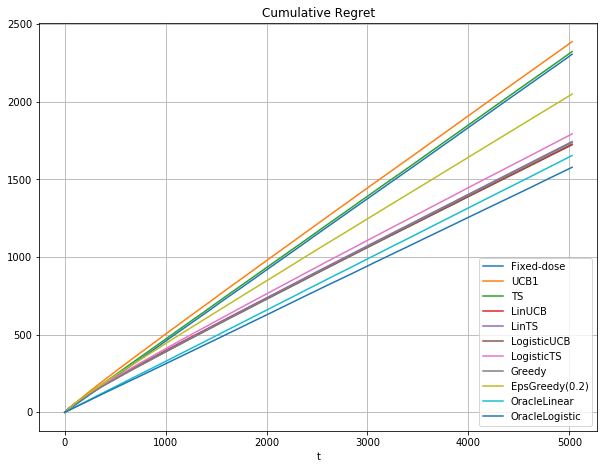

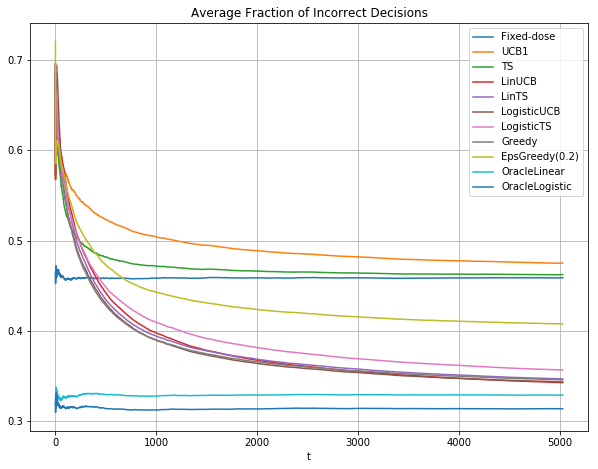

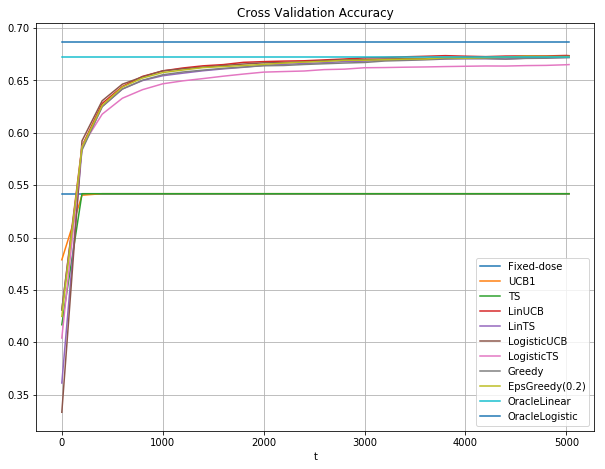

In [5]:
# Instantiate a Warfarin simulator
discretizer = discretize_label_3
simulator = WarfarinSimulator(DATA_PATH, discretizer, test_size=500, add_bias=True)

num_arms = simulator.num_arms
num_features = simulator.num_features

# Simulate the policies and compare performance
reward_history_dict, val_accuracy_dict, val_step_dict = simulate_policies(simulator, [
    (WarfarinFixedDosePolicy(1), "Fixed-dose"),
    (UCB1Policy(num_arms), "UCB1"),
    (BernoulliThompsonPolicy(num_arms), "TS"),
    (LinUCBPolicy(num_features, num_arms, alpha=0.5), "LinUCB"),
    (LinearThompsonPolicy(num_features, num_arms, v=0.01), "LinTS"),
    (LogisticUCBPolicy(num_features, num_arms, alpha=1.0), "LogisticUCB"),
    (LogisticThompsonPolicy(num_features, num_arms, l=1.0, alpha=0.5), "LogisticTS"),
    (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0), "Greedy"),
    # (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda t: 0.2-t/20000), "EpsDecay"),
    (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0.2), "EpsGreedy(0.2)"),
    (WarfarinLinearOraclePolicy(DATA_PATH, discretizer), "OracleLinear"),
    (WarfarinLogisticOraclePolicy(DATA_PATH, discretizer), "OracleLogistic"),
], num_runs=200, eval_every=200)

visualize_simulation_results(reward_history_dict, val_accuracy_dict, val_step_dict)

In [6]:
# Look at how often LinUCB chooses "suboptimal" actions in order to explore
# Conclusion: It is quite actively exploring!

discretizer = discretize_label_3
simulator = WarfarinSimulator(DATA_PATH, discretizer, test_size=500, add_bias=True)
linucb = LinUCBPolicy(simulator.num_features, simulator.num_arms, alpha=1.0)
count = []
for i in range(10):
    linucb.reset()
    simulator.simulate(linucb, eval_every=10000)
    count.append(linucb.get_num_suboptimal_actions())
print(np.mean(count))
print(count)

Instantiated a Warfarin Bandit simulator!
Reward structure: binary
Number of arms: 3
Number of features: 24
Size of training set for online learning: 5028
Size of holdout validation set: 500
406.5
[422, 379, 408, 434, 435, 404, 402, 378, 383, 420]


# Simulate with nine arms

Instantiated a Warfarin Bandit simulator!
Reward structure: binary
Number of arms: 9
Number of features: 24
Size of training set for online learning: 5028
Size of holdout validation set: 500
Start simulating Fixed-dose for 200 times
200/200 [==============================] - 15s    
Fixed-dose average regret: 4089
Start simulating UCB1 for 200 times
200/200 [==============================] - 54s    
UCB1 average regret: 4248
Start simulating TS for 200 times
200/200 [==============================] - 54s    
TS average regret: 4032
Start simulating LinUCB for 200 times
200/200 [==============================] - 115s   
LinUCB average regret: 3772
Start simulating LinTS for 200 times
200/200 [==============================] - 2535s   
LinTS average regret: 3742
Start simulating LogisticUCB for 200 times
200/200 [==============================] - 2310s   
LogisticUCB average regret: 3738
Start simulating LogisticTS for 200 times
200/200 [==============================] - 1082s  
Logistic

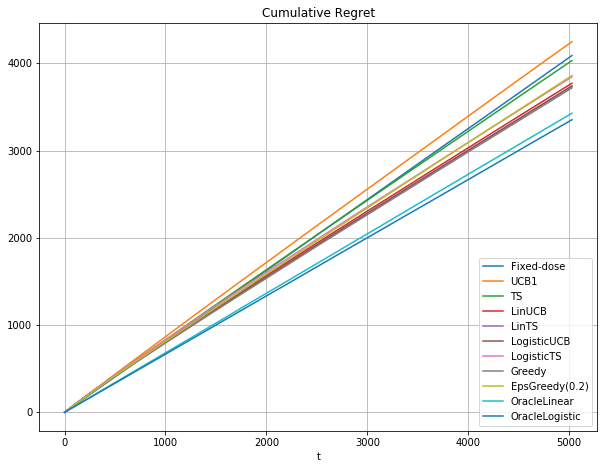

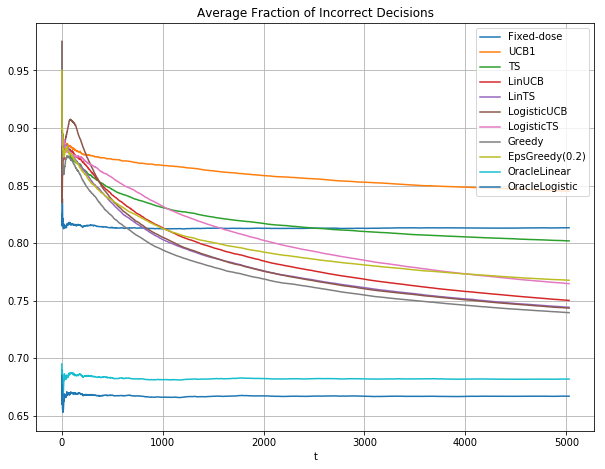

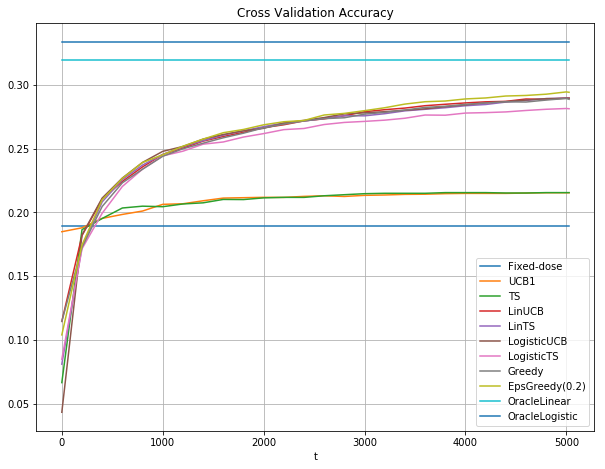

In [7]:
# Instantiate a Warfarin simulator
discretizer = discretize_label_9
simulator = WarfarinSimulator(DATA_PATH, discretizer, test_size=500, add_bias=True)

num_arms = simulator.num_arms
num_features = simulator.num_features

# Simulate the policies and compare performance
reward_history_dict, val_accuracy_dict, val_step_dict = simulate_policies(simulator, [
    (WarfarinFixedDosePolicy(1), "Fixed-dose"),
    (UCB1Policy(num_arms), "UCB1"),
    (BernoulliThompsonPolicy(num_arms), "TS"),
    (LinUCBPolicy(num_features, num_arms, alpha=0.5), "LinUCB"),
    (LinearThompsonPolicy(num_features, num_arms, v=0.01), "LinTS"),
    (LogisticUCBPolicy(num_features, num_arms, alpha=1.0), "LogisticUCB"),
    (LogisticThompsonPolicy(num_features, num_arms, l=1.0, alpha=0.5), "LogisticTS"),
    (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0), "Greedy"),
    # (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda t: 0.2-t/20000), "EpsDecay"),
    (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0.2), "EpsGreedy(0.2)"),
    (WarfarinLinearOraclePolicy(DATA_PATH, discretizer), "OracleLinear"),
    (WarfarinLogisticOraclePolicy(DATA_PATH, discretizer), "OracleLogistic"),
], num_runs=200, eval_every=200)

visualize_simulation_results(reward_history_dict, val_accuracy_dict, val_step_dict)

In [8]:
# Compared to 3 arms, LinUCB explores much much more!

discretizer = discretize_label_9
simulator = WarfarinSimulator(DATA_PATH, discretizer, test_size=500, add_bias=True)
linucb = LinUCBPolicy(simulator.num_features, simulator.num_arms, alpha=1.0)
count = []
for i in range(10):
    linucb.reset()
    simulator.simulate(linucb, eval_every=10000)
    count.append(linucb.get_num_suboptimal_actions())
print(np.mean(count))
print(count)

Instantiated a Warfarin Bandit simulator!
Reward structure: binary
Number of arms: 9
Number of features: 24
Size of training set for online learning: 5028
Size of holdout validation set: 500
1400.1
[1381, 1421, 1355, 1278, 1341, 1539, 1444, 1353, 1459, 1430]
